In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dl-itba-cifar-100-2024-q-1/y_train_fine.npy
/kaggle/input/dl-itba-cifar-100-2024-q-1/y_train_coarse.npy
/kaggle/input/dl-itba-cifar-100-2024-q-1/fine_label_names.pck
/kaggle/input/dl-itba-cifar-100-2024-q-1/coarse_label_names.pck
/kaggle/input/dl-itba-cifar-100-2024-q-1/x_test.npy
/kaggle/input/dl-itba-cifar-100-2024-q-1/x_train.npy


**Librerías necesarias (comentadas las que no fueron utilizadas en el modelo final)**

In [41]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
#from tensorflow.keras.regularizers import l1, l2
#from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

**Cargamos la data**

In [42]:
x_train = np.load("/kaggle/input/dl-itba-cifar-100-2024-q-1/x_train.npy")/255.
x_test = np.load("/kaggle/input/dl-itba-cifar-100-2024-q-1/x_test.npy")/255.
y_train_coarse = np.load("/kaggle/input/dl-itba-cifar-100-2024-q-1/y_train_coarse.npy")
y_train_fine = np.load("/kaggle/input/dl-itba-cifar-100-2024-q-1/y_train_fine.npy")

In [43]:
import pickle
with open("/kaggle/input/dl-itba-cifar-100-2024-q-1/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)
with open("/kaggle/input/dl-itba-cifar-100-2024-q-1/coarse_label_names.pck", "rb") as f:
    labels_coarse = pickle.load(f)

**Separamos la data en train y validation** 

In [44]:
x_train, x_val, y_train_fine, y_val_fine = train_test_split(
                                           x_train, y_train_fine, test_size=0.1, stratify=y_train_fine
)

**Data augmentation: flippeando las imagenes horizontalmente y desplazandolas**

In [56]:
# Flip horizontal
x_train_bis = x_train[:, :, ::-1, :]
x_train_dup = np.concatenate([x_train, x_train_bis], axis=0)

# Crear etiquetas duplicadas
y_train_fine_dup = np.concatenate([y_train_fine, y_train_fine], axis=0)

# Más augmentations

#Copias para otras augmentations
x_train_bis = x_train_dup.copy()
x_train_bis_bis = x_train_dup.copy()

#Desplazamiento de las imágenes
x_train_bis[:, :, 1:, :] = x_train_dup[:, :, :-1, :]
x_train_bis_bis[:, :, :-1, :] = x_train_dup[:, :, 1:, :]

x_train_dup = np.concatenate([x_train_dup, x_train_bis, x_train_bis_bis], axis=0)
y_train_fine_dup = np.concatenate([y_train_fine_dup, y_train_fine_dup, y_train_fine_dup], axis=0)

#print(x_train_dup.shape)
#print(y_train_fine_dup.shape)

(90000, 32, 32, 3)
(90000,)


In [59]:
# Definimos los callbacks

rlrop = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-5
)

mc = ModelCheckpoint(
    "best_weights.weights.h5",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
)

es = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

# Modelo

Comenzamos agregándole 3 capas con 1024, 512 y 256 neuronas. Luego probamos agregando una cuarta con 128. Con la cuarta nos disminuyó el overfitting. Además, probamos implementar L2 en cada que mejoraba el gap entre train y validation (overfitting), pero nos bajaba el valor del acurracy asique decidimos eliminarlo. 
Hicimos un dropout out primero con 0.2 que nos dio un overfitteo grande ya que el gap era muy grande y “estaba aprendiendo de memoria”. Lo cambiamos por un 0.3.

In [60]:
model = Sequential()

# Aplanar las imágenes de entrada
model.add(Flatten(input_shape=(32, 32, 3)))

# Primera capa densa
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Segunda capa densa
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Tercera capa densa
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Cuarta capa densa
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Capa de salida
model.add(Dense(100, activation="softmax"))

# Compilación del modelo
model.compile(
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"], 
    optimizer=Adam(learning_rate=0.001)
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,856,356 (14.71 MB)

 Trainable params: 3,852,516 (14.70 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [ ]:
tb = TensorBoard(
    log_dir="logs",
)

**Entrenamos el modelo**

In [62]:
history = model.fit(
    x = x_train_dup, 
    y = y_train_fine_dup, 
    batch_size=32, 
    epochs=50, 
    validation_data = (x_val, y_val_fine), 
    callbacks= [
        rlrop,
        es,
        mc
    ]
)

Epoch 1/50
8438/8438 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1035 - loss: 3.9209
Epoch 1: val_accuracy improved from -inf to 0.18880, saving model to best_weights.weights.h5
8438/8438 ━━━━━━━━━━━━━━━━━━━━ 254s 30ms/step - accuracy: 0.1035 - loss: 3.9209 - val_accuracy: 0.1888 - val_loss: 3.3401 - learning_rate: 0.0010
Epoch 2/50
8437/8438 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1842 - loss: 3.4077
Epoch 2: val_accuracy improved from 0.18880 to 0.22220, saving model to best_weights.weights.h5
8438/8438 ━━━━━━━━━━━━━━━━━━━━ 251s 30ms/step - accuracy: 0.1842 - loss: 3.4076 - val_accuracy: 0.2222 - val_loss: 3.1740 - learning_rate: 0.0010
Epoch 3/50
8438/8438 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2118 - loss: 3.2526
Epoch 3: val_accuracy improved from 0.22220 to 0.24320, saving model to best_weights.weights.h5
8438/8438 ━━━━━━━━━━━━━━━━━━━━ 254s 30ms/step - accuracy: 0.2118 - loss: 3.2526 - val_accuracy: 0.2432 - val_loss: 3.0565 - learning_rate: 0.0010
Epoch 4/50

In [ ]:
!mkdir logs

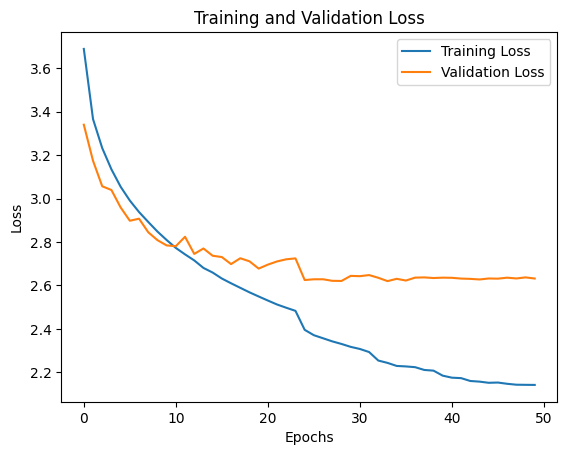

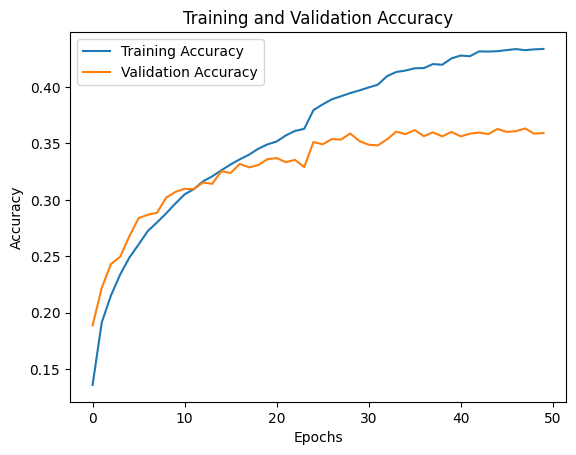

In [63]:
# Gráfico del loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Gráfico del accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
#%tensorboard --logdir logs

In [64]:
predictions = model.predict(x_test).argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [65]:
df = pd.DataFrame(predictions, columns=["Label"])

In [69]:
df
df.index.name = "Id"
df.to_csv("submission.csv")